In [43]:
from collections import namedtuple, OrderedDict
import itertools
import os
import numpy as np
from typing import Tuple
from typing import List
from typing import Dict
import random
from itertools import product
import copy
import re
import random

from utils import one_hot
from utils import generate_possible_object_names
from utils import numpy_array_to_image

from vocabulary import *
from object_vocabulary import *
from world import *
from grammer import *
from simulator import *
from relation_graph import *

### Vocabulary Module

In [44]:
# test out the vocabulary
intransitive_verbs = ["walk"]
transitive_verbs = ["push", "pull"]
adverbs = ["while zigzagging", "while spinning", "cautiously", "hesitantly"]
nouns = ["circle", "cylinder", "square", "box"]
color_adjectives = ["red", "blue", "green", "yellow"]
size_adjectives = ["big", "small"]
relative_pronouns = ["that is"]
relation_clauses = ["in the same row as", 
                    "in the same column as", 
                    "in the same color as", 
                    "in the same shape as", 
                    "in the same size as",
                    "inside of"]
vocabulary = Vocabulary.initialize(intransitive_verbs=intransitive_verbs,
                                   transitive_verbs=transitive_verbs, adverbs=adverbs, nouns=nouns,
                                   color_adjectives=color_adjectives,
                                   size_adjectives=size_adjectives, 
                                   relative_pronouns=relative_pronouns, 
                                   relation_clauses=relation_clauses)

In [45]:
# test out the object vocab
min_object_size = 1
max_object_size = 4
object_vocabulary = ObjectVocabulary(shapes=vocabulary.get_semantic_shapes(),
                                     colors=vocabulary.get_semantic_colors(),
                                     min_size=min_object_size, max_size=max_object_size)
# object_vocabulary.generate_objects()

### Situtation Module

In [46]:
# test out situation repr
TEST_SITUATION_1 = Situation(grid_size=15, agent_position=Position(row=7, column=2), agent_direction=INT_TO_DIR[0],
                             target_object=PositionedObject(object=Object(size=2, color='red', shape='circle'),
                                                            position=Position(row=10, column=4),
                                                            vector=np.array([1, 0, 1])),
                             placed_objects=[PositionedObject(object=Object(size=2, color='red', shape='circle'),
                                                              position=Position(row=10, column=4),
                                                              vector=np.array([1, 0, 1])),
                                             PositionedObject(object=Object(size=4, color='green', shape='circle'),
                                                              position=Position(row=3, column=12),
                                                              vector=np.array([0, 1, 0]))], carrying=None)
# TEST_SITUATION_1.to_representation()

In [47]:
# test out our new object definition
PositionedObject(object=Object(size=4, color='green', shape='box'),
                 position=Position(row=3, column=12),
                 vector=np.array([0, 1, 0]), overflow=True, overlap=True)

PositionedObject(object=Object(size=4, color='green', shape='box'), position=Position(column=12, row=3), vector=array([0, 1, 0]), overflow=True, overlap=True)

### World Module with Mini-Gym

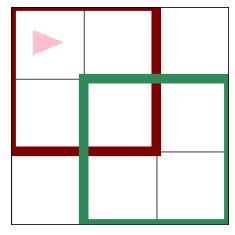

True

In [48]:
# test out the world
import matplotlib as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
os.environ['QT_QPA_PLATFORM']='offscreen'

world = World(grid_size=3, colors=vocabulary.get_semantic_colors(),
              object_vocabulary=object_vocabulary,
              shapes=vocabulary.get_semantic_shapes(),
              save_directory="./tmp/")

world.place_object(Object(size=2, color="green", shape="box"), position=Position(row=1, column=1))
world.place_object(Object(size=2, color="red", shape="box"), position=Position(row=0, column=0))
_ = world.render_simple()
world.position_taken(position=Position(row=0, column=0), condition="box")


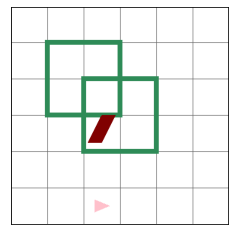

In [49]:
world = World(grid_size=6, colors=vocabulary.get_semantic_colors(),
              object_vocabulary=object_vocabulary,
              shapes=vocabulary.get_semantic_shapes(),
              save_directory="./tmp/")

# try to place an object on to the map
world.clear_situation()
# world.place_object(Object(size=4, color="green", shape="box"), position=Position(row=3, column=3))
world.place_object(Object(size=2, color="green", shape="box"), position=Position(row=2, column=2))
world.place_object(Object(size=2, color="green", shape="box"), position=Position(row=1, column=1))
world.place_object(Object(size=3, color="red", shape="cylinder"), position=Position(row=3, column=2))
world.place_agent_at(Position(row=5, column=2))

_ = world.render_simple()

verb = "push"
adverb = "cautiously"

# Direct walk.
action = "walk" # this is definit!
primitive_command = vocabulary.translate_word(action)
target_position = Position(row=3, column=2)
# simulator._world.get_current_situation().to_dict()["target_object"].position
world.go_to_position(position=target_position, manner=adverb, primitive_command=primitive_command)

# Object actions.
if True:
    semantic_action = vocabulary.translate_word(verb)
    world.move_object_to_wall(action=semantic_action, manner=adverb)
target_commands, target_demonstration = world.get_current_observations()

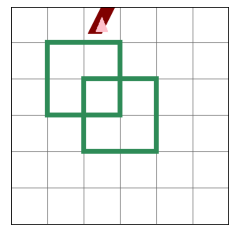

In [50]:
_ = world.render_simple()

### ReaSCAN Grammer Module

In [51]:
grammer = Grammer(vocabulary)
vocabulary.get_transitive_verbs() + vocabulary.get_intransitive_verbs()

['push', 'pull', 'walk']

In [52]:
grammer_pattern = '$OBJ_0 ^ $OBJ_1 & $OBJ_2'

relations = grammer.sample_object_relation_grammer(
    '$OBJ_0', 
    grammer.build_dependency_graph(grammer_pattern))

command_structs = []
for relation in relations:
    obj_pattern_map = relation[0]
    rel_map = relation[1]
    grammer_bindings = grammer.grounding_grammer_with_vocabulary(grammer_pattern, obj_pattern_map, rel_map)
    for obj_map in grammer_bindings:
        # here, we also sample the verb and adverb bindings!
        
        command_struct = {
            "obj_pattern_map" : obj_pattern_map,
            "rel_map" : rel_map,
            "obj_map" : obj_map,
            "grammer_pattern" : grammer_pattern,
            "adverb" : random.choice(vocabulary.get_adverbs()),
            "verb" : random.choice(vocabulary.get_transitive_verbs() + vocabulary.get_intransitive_verbs()),
        }
        command_structs += [command_struct]

In [ ]:
# command_struct_stats = get_command_struct_statistics(command_structs)

### ReaSCAN Simulator

In [ ]:
simulator = Simulator(
    object_vocabulary, vocabulary, 
    grid_size=6, 
    n_object_max=10,
)

In [ ]:
obj_pattern_map = {'$OBJ_0': '$ABS_SHAPE', '$OBJ_1': '$SHAPE', '$OBJ_2': '$SHAPE'}
rel_map = {('$OBJ_0', '$OBJ_1'): '$SAME_SHAPE', ('$OBJ_0', '$OBJ_2'): '$IS_INSIDE'}
obj_map = {'$OBJ_0': 'object', '$OBJ_1': 'circle', '$OBJ_2': 'box'}
grammer_pattern = '$OBJ_0 ^ $OBJ_1 & $OBJ_2'
verb = "push"
adverb = "slowly"
sampled_world = simulator.sample_situations_from_grounded_grammer(
    copy.deepcopy(grammer_pattern), 
    copy.deepcopy(obj_pattern_map), 
    copy.deepcopy(rel_map), 
    copy.deepcopy(obj_map),
    is_plot=True,
    include_relation_distractor=False, 
    include_attribute_distractor=False, 
    include_isomorphism_distractor=False, 
    include_random_distractor=False,
    full_relation_probability=0.5,
    debug=False
)

In [ ]:
is_transitive = False
if verb in simulator.vocabulary.get_transitive_verbs():
    is_transitive = True

# Direct walk.
action = "walk" # this is definit!
primitive_command = simulator.vocabulary.translate_word(action)
target_position = sampled_world["situation"].target_object.position

simulator._world.go_to_position(position=target_position, manner=adverb, primitive_command=primitive_command)

# Object actions.
if is_transitive:
    semantic_action = simulator.vocabulary.translate_word(verb)
    simulator._world.move_object_to_wall(action=semantic_action, manner=adverb)
target_commands, target_demonstration = simulator._world.get_current_observations()

In [ ]:
target_commands

### End-to-end Task Generation

In [60]:
class Simulator(object):
    """
    This convert generated grammers into a world/situation.
    
    Sample Situation:
    Situation(grid_size=15, agent_position=Position(row=7, column=2), agent_direction=INT_TO_DIR[0],
              target_object=PositionedObject(object=Object(size=2, color='red', shape='circle'),
                                             position=Position(row=10, column=4),
                                             vector=np.array([1, 0, 1])),
              placed_objects=[PositionedObject(object=Object(size=2, color='red', shape='circle'),
                                               position=Position(row=10, column=4),
                                               vector=np.array([1, 0, 1])),
                              PositionedObject(object=Object(size=4, color='green', shape='circle'),
                                               position=Position(row=3, column=12),
                                               vector=np.array([0, 1, 0]))], carrying=None)
                                               
    Sample Placement in the World:
    world.place_object(Object(size=2, color="green", shape="box"), position=Position(row=2, column=2))
    
    """
    def __init__(self, object_vocabulary, vocabulary, grid_size=6, 
                 n_object_min=6,
                 n_object_max=12,
                 save_directory="./tmp/"):
        self.object_vocabulary = object_vocabulary
        self.vocabulary = vocabulary
        self.grid_size = grid_size
        self.n_object_min = n_object_min
        self.n_object_max = n_object_max

        self._world = World(grid_size=grid_size, colors=vocabulary.get_semantic_colors(),
                            object_vocabulary=object_vocabulary,
                            shapes=vocabulary.get_semantic_shapes(),
                            save_directory=save_directory)
        self._world.clear_situation()
    
    def sample_object_shape(
        self, obj_grammer, obj_pattern, obj_str, rel_map, 
        is_root, shape_map
    ):
        obj_pattern = obj_pattern.split(" ")
        obj_str = obj_str.split(" ")
        shape = None
        if len(obj_str) == 3:
            shape = obj_str[2]
        elif len(obj_str) == 2:
            shape = obj_str[1]
        elif len(obj_str) == 1:
            # it must be the object
            shape = obj_str[0]
        # Final handling for the shape.
        if shape == "object":
            shape = self.object_vocabulary.sample_shape()
            
        # Override size, color and shape based on relations.
        if not is_root:
            # Go through the rel.
            for pair, rel in rel_map.items():
                if obj_grammer == pair[-1]:
                    if pair[0] in shape_map.keys():
                        # if this obj is acting as a child node
                        # then have to complain with parent node
                        if rel == "$SAME_SHAPE":
                            shape = shape_map[pair[0]]
                        elif rel == "$IS_INSIDE":
                            shape = "box"
        return shape
    
    def sample_object_spec(
        self, obj_grammer, obj_pattern, obj_str, rel_map, 
        is_root, obj_placed_map, 
        size_restriction_map=None,
        mentioned_shapes=None
    ):
        obj_pattern = obj_pattern.split(" ")
        obj_str = obj_str.split(" ")
        color = None
        size = None
        shape = None
        if len(obj_str) == 3:
            size = self.object_vocabulary.sample_size_with_prior(prior=obj_str[0])
            color = obj_str[1]
            shape = obj_str[2]
        elif len(obj_str) == 2:
            if "$COLOR" in obj_pattern: # color + shape.
                size = self.object_vocabulary.sample_size()
                color = obj_str[0]
                shape = obj_str[1]
            elif "$SIZE" in obj_pattern: # size + shape.
                size = self.object_vocabulary.sample_size_with_prior(prior=obj_str[0])
                color = self.object_vocabulary.sample_color()
                shape = obj_str[1]
        elif len(obj_str) == 1:
            # it must be the object
            size = self.object_vocabulary.sample_size()
            color = self.object_vocabulary.sample_color()
            shape = obj_str[0]
        # Final handling for the shape.
        if shape == "object":
            # WARNING: this is a corner case you will hit
            # if your logic chain is long, you may need to
            # consider remove object option!
            if mentioned_shapes != None and len(mentioned_shapes) == self.object_vocabulary._shapes:
                assert False
            if is_root:
                shape = self.object_vocabulary.sample_shape() # _exclude=mentioned_shapes
            else:
                shape = self.object_vocabulary.sample_shape()
                
        return Object(color=color,size=size,shape=shape)
                    
    def sample_object_position(
        self, sampled_obj, root, obj_grammer, 
        rel_map, obj_placed_map, 
        obj_position_map
    ):
        """
        Return:
        -1: No position can be sampled.
        """
        # If it is the first node, we directly return.
        if sampled_obj.shape != "box":
            obj_random_pos = self._world.sample_position_complex(
                condition="normal", sample_one=True
            )
        else:
            obj_random_pos = self._world.sample_position_complex(
                condition="box", box_size=sampled_obj.size, sample_one=True
            )
        if obj_grammer == root:
            return obj_random_pos # for this round, the root node can be placed anywhere!
        
        # For some relations, we might need to resample positions!
        for pair, rel in rel_map.items():
            if obj_grammer == pair[-1]:
                if not pair[0] in obj_placed_map.keys():
                    assert False # this should never be the case! the position sampling in from top to bottom!

                # if this obj is acting as a child node
                # then have to complain with parent node
                if rel == "$SAME_ROW":
                    row = obj_position_map[pair[0]].row
                    for i in range(0, self.grid_size):
                        proposed_position = Position(row=row, column=i)
                        if not self._world.position_taken(proposed_position, condition="normal"):
                            return proposed_position
                    return -1 # too many objs
                if rel == "$SAME_COLUMN":
                    col = obj_position_map[pair[0]].column
                    for i in range(0, self.grid_size):
                        proposed_position = Position(row=i, column=col)
                        if not self._world.position_taken(proposed_position, condition="normal"):
                            return proposed_position
                    return -1 # too many objs
                elif rel == "$IS_INSIDE":
                    # we need to make sure enclosure
                    assert sampled_obj.shape == "box"
                    size = sampled_obj.size
                    potential_positions = []
                    row = obj_position_map[pair[0]].row
                    col = obj_position_map[pair[0]].column
                    for i in range(0, self.grid_size-size+1):
                        for j in range(0, self.grid_size-size+1):
                            # we need to cover the is inside obj
                            if row >= i and row < i + sampled_obj.size and \
                                col >= j and col < j + sampled_obj.size:
                                proposed_position = Position(row=i, column=j)
                                if not self._world.position_taken(proposed_position, condition="box"):
                                    potential_positions.append(Position(row=i, column=j))
                    random.shuffle(potential_positions)
                    if len(potential_positions) < 1:
                        return -1
                    return potential_positions[0]

        return obj_random_pos
    
    def sample_random_object_spec(
        self, 
        size_exclude=None, 
        color_exclude=None, shape_exclude=None
    ):
        d_size = self.object_vocabulary.sample_size(_exclude=size_exclude)
        d_color = self.object_vocabulary.sample_color(_exclude=color_exclude)
        d_shape = self.object_vocabulary.sample_shape(_exclude=shape_exclude)
        return Object(color=d_color,size=d_size,shape=d_shape)
    
    def place_distractor_from_dict(
        self, distractors_dict, 
        obj_placed_map, obj_position_map, 
        debug=False, 
        special_shape_size_bound=None,
        mentioned_shapes=None,
    ):
        if debug:
            import pprint
            pp = pprint.PrettyPrinter(indent=4)
            pp.pprint(distractors_dict)
        distractor_root = f"$OBJ_{len(obj_placed_map)}"
        success = True
        distractors_obj_map = distractors_dict["obj_map"]
        distractors_rel_map = distractors_dict["rel_map"]
        distractors_obj_pattern_map = distractors_dict["obj_pattern_map"]
        distractors_size_map = distractors_dict["size_map"]
        
        distractors_sampled_obj_map = {}
        for dis_grammer, dis_str in distractors_obj_map.items():
            # 1. Sample object.
            sampled_dis = self.sample_object_spec(
                dis_grammer,
                distractors_obj_pattern_map[dis_grammer], 
                dis_str, distractors_rel_map, 
                is_root=dis_grammer==distractor_root, 
                obj_placed_map=obj_placed_map,
                mentioned_shapes=mentioned_shapes,
            )
            # 1.1. Update the size of the object if needed.
            if dis_grammer in distractors_size_map.keys():
                sampled_dis = Object(
                    color=sampled_dis.color,
                    size=distractors_size_map[dis_grammer],
                    shape=sampled_dis.shape
                )
            # 1.2. Another pass of override by using global constraints.
            special_shape_super = sampled_dis.shape
            special_shape_sub = sampled_dis.color + " " + sampled_dis.shape
            # e.g., small circle exists in the command, then any colored circle needs to be constrain
            if special_shape_super in special_shape_size_bound.keys():
                if "small" in dis_str:
                    updated_size = special_shape_size_bound[special_shape_super][0]
                else:
                    updated_size = special_shape_size_bound[special_shape_super][1]
                sampled_dis = Object(
                    color=sampled_dis.color,
                    size=updated_size,
                    shape=sampled_dis.shape
                )
            elif special_shape_sub in special_shape_size_bound.keys():
                if "small" in dis_str:
                    updated_size = special_shape_size_bound[special_shape_sub][0]
                else:
                    updated_size = special_shape_size_bound[special_shape_sub][1]
                sampled_dis = Object(
                    color=sampled_dis.color,
                    size=updated_size,
                    shape=sampled_dis.shape
                )
            else:
                pass # Do nothing.
            distractors_sampled_obj_map[dis_grammer] = sampled_dis
        
        # 2. Update it using relationships.
        for pair, rel in distractors_rel_map.items():
            if rel == "$SAME_SHAPE":
                pass
            elif rel == "$SAME_COLOR":
                pass
            elif rel == "$SAME_SIZE":
                # Update the src node size information.
                size = distractors_sampled_obj_map[pair[1]].size
                distractors_sampled_obj_map[pair[0]] = Object(
                    color=distractors_sampled_obj_map[pair[0]].color,
                    size=size,
                    shape=distractors_sampled_obj_map[pair[0]].shape
                )
            elif rel == "$IS_INSIDE":
                pass # Do nothing!

        placed_dis_grammer = []
        for dis_grammer, sampled_dis in distractors_sampled_obj_map.items():
            # 2. Place on the world map.
            sampled_pos = self.sample_object_position(
                sampled_dis, distractor_root, 
                dis_grammer, distractors_rel_map, 
                obj_placed_map, obj_position_map
            )

            if sampled_dis == -1 or sampled_pos == -1:
                # We allow partial placement as they add difficulties!
                return False

            return_code = self._world.place_object(
                sampled_dis, 
                position=sampled_pos, target=False # Distractor is never the target!
            )
            if return_code == -1:
                print(obj_placed_map)
                print(obj_position_map)
                print(distractors_dict)
                print(self._world.grid.get(sampled_pos.column, sampled_pos.row))
                FAIL()
            obj_placed_map[dis_grammer] = sampled_dis
            obj_position_map[dis_grammer] = sampled_pos
            
        return True
    
    def sample_situations_from_grounded_grammer(
        self, grammer_pattern, 
        obj_pattern_map, rel_map, obj_map, root="$OBJ_0", 
        is_plot=False, 
        include_random_distractor=False, 
        include_relation_distractor=False, 
        include_attribute_distractor=False, 
        include_isomorphism_distractor=False, 
        full_relation_probability=0.5,
        debug=False,
    ):
        # Clear current world.
        self._world.clear_situation()
        
        # Start placing objects with specs.
        obj_placed_map = OrderedDict({})
        obj_position_map = OrderedDict({})
        referred_obj = root
        
        # Preliminary size check!
        """
        Here is a list of potential internal conflicts:
        (1) ... to a small box ... to a yellow box ...
        Explain: we need to adjust the size of two boxes
        so that small box has 1 size, and all other boxes 
        have the same other size.
        There will at max two different size of same type objects.
        
        So this is the rule:
        For 1 type of shape, max two different sizes.
        """
        # Ok, we need to determine shapes first!
        # Even there is any abstract object, the
        # shape is now determined.
        object_map = {}
        mentioned_shapes = set([]) # this is used to sample shapes for object.
        for obj_grammer, obj_str in obj_map.items():
            shape = self.extract_shape(obj_str)
            if shape != "":
                mentioned_shapes.add(shape)
        for obj_grammer, obj_str in obj_map.items():
            # 1. Sample object.
            sampled_obj = self.sample_object_spec(
                obj_grammer,
                obj_pattern_map[obj_grammer], obj_str, rel_map, 
                is_root=obj_grammer==root, 
                obj_placed_map=object_map,
                mentioned_shapes=mentioned_shapes,
            )
            object_map[obj_grammer] = sampled_obj
        
        # Next, we update all of them based on relations.
        # Final pass, we need to change attributes of objects based
        # on relations.
        # Here, we only change size!
        for pair, rel in rel_map.items():
            if rel == "$SAME_SHAPE":
                # Update the src node shape information.
                shape = object_map[pair[1]].shape
                object_map[pair[0]] = Object(
                    color=object_map[pair[0]].color,
                    size=object_map[pair[0]].size,
                    shape=shape
                )
                pass
            elif rel == "$SAME_COLOR":
                # Update the src node color information.
                color = object_map[pair[1]].color
                object_map[pair[0]] = Object(
                    color=color,
                    size=object_map[pair[0]].size,
                    shape=object_map[pair[0]].shape
                )
                pass
            elif rel == "$SAME_SIZE":
                # Update the src node size information.
                size = object_map[pair[1]].size
                object_map[pair[0]] = Object(
                    color=object_map[pair[0]].color,
                    size=size,
                    shape=object_map[pair[0]].shape
                )
            elif rel == "$IS_INSIDE":
                pass
            
        # Then, we will determine size bounds.
        special_shape_size_bound = {}
        for obj_grammer, obj_pattern in obj_pattern_map.items():
            
            small_size = random.randint(
                self.object_vocabulary._min_size, 
                self.object_vocabulary._max_size-1
            )
            big_size = random.randint(
                small_size+1, 
                self.object_vocabulary._max_size
            )
            
            if "$SIZE" in obj_pattern and "$COLOR" in obj_pattern:
                special_shape = object_map[obj_grammer].color + " " + object_map[obj_grammer].shape
                if object_map[obj_grammer].shape in special_shape_size_bound.keys():
                    # e.g., small circle exists
                    special_shape_size_bound[special_shape] = special_shape_size_bound[object_map[obj_grammer].shape]
                else:
                    # e.g., small yellow circle
                    special_shape_size_bound[special_shape] = [small_size, big_size]
            elif "$SIZE" in obj_pattern and not "$COLOR" in obj_pattern:
                # e.g., small circle
                # overwrite any existing bounds.
                special_shape = object_map[obj_grammer].shape
                for ss, bound in special_shape_size_bound.items():
                    if special_shape in ss:
                        special_shape_size_bound[ss] = [small_size, big_size]
                # for shape, it adds.
                special_shape_size_bound[special_shape] = [small_size, big_size]
                # for non-sized shape, it also adds as long as shape is the same.
                for obj_grammer, obj_pattern in obj_pattern_map.items():
                    if special_shape in obj_map[obj_grammer]:
                        if "$COLOR" in obj_pattern:
                            special_shape = object_map[obj_grammer].color + " " + object_map[obj_grammer].shape
                            special_shape_size_bound[special_shape] = [small_size, big_size]
            else:
                continue
        
        # Update object size based on global scanning results.
        updated_object_map = {}
        for obj_grammer, obj_pattern in obj_pattern_map.items():

            special_shape_super = object_map[obj_grammer].shape
            special_shape_sub = object_map[obj_grammer].color + " " + object_map[obj_grammer].shape
            
            # e.g., small circle exists in the command, then any colored circle needs to be constrain
            if special_shape_super in special_shape_size_bound.keys():
                if "small" in obj_map[obj_grammer]:
                    updated_size = special_shape_size_bound[special_shape_super][0]
                else:
                    updated_size = special_shape_size_bound[special_shape_super][1]
                updated_object_map[obj_grammer] = Object(
                    color=object_map[obj_grammer].color,
                    size=updated_size,
                    shape=object_map[obj_grammer].shape
                )
            elif special_shape_sub in special_shape_size_bound.keys():
                if "small" in obj_map[obj_grammer]:
                    updated_size = special_shape_size_bound[special_shape_sub][0]
                else:
                    updated_size = special_shape_size_bound[special_shape_sub][1]
                updated_object_map[obj_grammer] = Object(
                    color=object_map[obj_grammer].color,
                    size=updated_size,
                    shape=object_map[obj_grammer].shape
                )
            else:
                # If nothing exists in the special size map, then we don't need
                # to alter the size.
                updated_object_map[obj_grammer] = object_map[obj_grammer]

        # Final pass, we need to change attributes of objects based
        # on relations.
        # Here, we only change size!
        for pair, rel in rel_map.items():
            if rel == "$SAME_SHAPE":
                pass
            elif rel == "$SAME_COLOR":
                pass
            elif rel == "$SAME_SIZE":
                # Update the src node size information.
                size = updated_object_map[pair[1]].size
                updated_object_map[pair[0]] = Object(
                    color=object_map[pair[0]].color,
                    size=size,
                    shape=object_map[pair[0]].shape
                )
            elif rel == "$IS_INSIDE":
                pass
        
        # Next, we sample positions of all objects and place them.
        for obj_grammer, obj_str in obj_map.items():
            # 1. Sample object (bu fetching the updated one).
            sampled_obj = updated_object_map[obj_grammer]
            
            # 2. Place on the world map.
            sampled_pos = self.sample_object_position(
                sampled_obj, root, obj_grammer, rel_map, 
                obj_placed_map, obj_position_map
            )
            
            if sampled_obj == -1 or sampled_pos == -1:
                assert False # we can assert false as it is impossible!
        
            self._world.place_object(
                sampled_obj, 
                position=sampled_pos, target=obj_grammer==root
            )
            obj_placed_map[obj_grammer] = sampled_obj
            obj_position_map[obj_grammer] = sampled_pos
            
        """
        Distractor Sampling Strategies and Design
        
        Giving a complex command as:
        "the small red circle(1) that is in the same row(a) 
        as a big green square(2) and that is in the same column(b) 
        as a small yellow cylinder(3)."
        
        We have 4 types of distractors (objects):
        - Attribute-based Distractors
        - Relation-based Distractors
        - Sytax-based Distractors
        - Random Distractors
        
        For each type of distractors, we will modify the command
        to generate a new command for distractors. Then, we will
        ensure such every command-world pair needs to reason about
        attribute, relation and syntax. 
        
        There are some caveats around this design. Due to the 
        complexity of the command, to make sure
        every attribute/relation is necessary becomes unfeasible. For
        example, if we want to make "small" in "the small red circle (1)"
        necessary, then, we need to put another non-"small" "red circle".
        This is easy. However, if we want to make "big" in "the big
        green square" necessary, we essentially need to sample another
        set of objects (at max 3) that complies with a modified command
        "the small red circle(1) that is in the same row(a) 
        as a small green square(2*) and that is in the same column(b) 
        as a small yellow cylinder(3)."
        
        Following this logic, if we want to make sure *every descriptor*\
        (i.e., every adjective) is necessary to identity the referent
        target, we could flood the system easily with way too many
        distractors that cannot fit in our grid world.
        
        On the other hand, the goal of having the distractors is to
        have the system learn the importantce of relations, attributes
        and linguistic syntax. So, are these distractors necessary?
        Do we need to actually have an exhaustive list of distractors
        for each command-world pair in order to have the model to learn
        this? We propose the answer is No, but Yes in the dataset level. In
        the command level, we will not make sure *every descriptor* is
        necessary, but in the command level, we will make sure 
        *every descriptor* matters for at least some of the command.
        Otherwise, the model may just completely ignores one part of
        the command and relies on the rest.
        
        In our design, we ensure for each command-world pair, some attribute
        and some relation and some syntax are needed. In the dataset
        level, we ensure different attribute, relation and syntax are 
        weighted equally.
        
        We propose to sample distractors following the design below:
        
        For a command such as
        "A that is X B and that is Y C"
        (1) We generate two distractor commands: "A that X B"; and "A that Y C"
        without guarantee all relations in the original command. This samples
        4 distractors. This ensures X and Y are necessary!
        
        (2) Next, we need to ensure that if we change some descriptors for
        A, B or C, referent target cannot be identified. For example, if
        we change B from "yellow square" to "blue square" the referent target
        should change. In this case, we need to sample a new set of {A,B,C}.
        And if we do this for each object, this results in 9 new distractors.
        If size is not selected, we potentially need 3 more distractors to
        ground the size aspects.
        
        (3) Next, to ensure model learns linguistic syntax, instead of simple
        BoW approach to represent the command, we would perform swap attributes
        between objects. We pick a pair of objects, and swap attributes 
        randomly. This results in 3 more distractors.
        
        (1) + (2) + (3) results in at max 19 distractors for each command-world pair.
        Plus the original 3 objects, we have in total 21 distractors.
        This is still a lot higher than gSCAN which is at max about 12.
        
        Then, we design another way to sample distractors:
        (1) We pick 1 relations from {X, Y}, and generate distracotrs: 3 distractors.
        
        (2) We pick 1 object from {A, B, C} and modify its attribute, sample 3 distractors.
        if size is not selected for any object, we need to randomly sample non-relational
        counterparts, at max 3.
        
        (3) Same, so 3.
        
        (1) + (2) + (3) results in 3 + 3 + 3 + 3 = 12, 12 + 3 -> at max 15. Is this doable?
        
        Test set. global v.s. local compositional generalization. In the test set, we 
        can pick different/more aspect of differeent/more obj that matter for the
        correctly reasonings, and generate test cases with  more distractors.
        """
        
        """
        Calling in this way to create distractors:

        simulator.sample_distractor_grammer_by_relation(
            grammer_pattern, 
            obj_pattern_map, 
            rel_map, 
            obj_map, 
            sampled_world
        )
        """
        temp_sampled_world = {
            "obj_map" : obj_placed_map,
            "pos_map" : obj_position_map,
            "referred_obj" : referred_obj,
            "situation" : copy.deepcopy(self._world.get_current_situation())
        }
        
        # Three types of distractor sampling for different purposes:
        # sample_distractor_grammer_by_relation()
        # - We will edit one leaf node, so that it makes sure
        #   the command is necessary!
        # sample_distractor_grammer_by_size()
        # - Size relatives need to be meaningful. We will add relational
        #   objects to make sure.
        # sample_distractor_grammer_by_isomorphism()
        # - This is to ensure syntax learning.
        
        distractor_switch_map = OrderedDict({
            "relation" : [],
            "attribute" : False,
            "isomorphism" : False, 
            "random" : False,
        })
        relation_distractors_dicts = [{
            "distractor_metadata": {}
        }]
        attribute_distractors_dicts = [{
            "distractor_metadata": {}
        }]
        isomorphism_distractors_dicts = [{
            "distractor_metadata": {}
        }]
        
        if random.random() < full_relation_probability:
            full_relation_set=True
        else:
            full_relation_set=False
            
        obj_drafted_count = len(obj_placed_map)
        if include_relation_distractor:
            """
            Relation Distractors: Count=3*n, at max 6.
            Relation Distractors (fast): Count=2*n, at max 4.
            """
            relation_distractors_dicts = self.sample_distractor_grammer_by_relation_fast(
                grammer_pattern, 
                obj_pattern_map, 
                rel_map, 
                obj_map, 
                temp_sampled_world,
                obj_base_count=len(obj_placed_map),
                full_set=full_relation_set,
            )
            if len(relation_distractors_dicts) == 0:
                pass # Size distractor is not applicable 
            else:
                distractor_switch = []
                is_full_relation = True
                for distractors_dict in relation_distractors_dicts:
                    obj_drafted_count += len(distractors_dict["obj_map"])
                    succeed = self.place_distractor_from_dict(
                        distractors_dict, 
                        obj_placed_map, 
                        obj_position_map,
                        debug=debug,
                        special_shape_size_bound=special_shape_size_bound,
                        mentioned_shapes=mentioned_shapes,
                        # This is needed as maybe distractors also 
                        # need to be bounded by global constraints.
                    )
                    if succeed:
                        distractor_switch_map["relation"].append(True)
                    else:
                        distractor_switch_map["relation"].append(False)

        if include_attribute_distractor:
            """
            Attribution Distractors: Count=3-6.
            """
            # If the command is small, we can overwrite this
            if len(rel_map) <= 1:
                full_set = True
            else:
                full_set = not full_relation_set
            attribute_distractors_dicts = self.sample_distractor_grammer_by_attribute(
                grammer_pattern, 
                obj_pattern_map, 
                rel_map, 
                obj_map, 
                temp_sampled_world,
                special_shape_size_bound,
                obj_base_count=obj_drafted_count, # This is important, as previous draft may success but placement can fail!
                full_set=full_set,
            )
            if len(attribute_distractors_dicts) == 0:
                pass # Size distractor is not applicable 
            else:
                obj_drafted_count += len(attribute_distractors_dicts[0]["obj_map"])
                succeed = self.place_distractor_from_dict(
                    attribute_distractors_dicts[0], 
                    obj_placed_map, 
                    obj_position_map,
                    debug=debug,
                    special_shape_size_bound=special_shape_size_bound,
                    mentioned_shapes=mentioned_shapes,
                    # This is needed as maybe distractors also 
                    # need to be bounded by global constraints.
                )
                if succeed:
                    distractor_switch_map["attribute"] = True # If one time it is true, it is true.
                else:
                    pass
        
        if include_isomorphism_distractor:
            """
            Syntax Distractors: Count=3.
            """
            isomorphism_distractors_dicts = self.sample_distractor_grammer_by_isomorphism(
                grammer_pattern, 
                obj_pattern_map, 
                rel_map, 
                obj_map, 
                temp_sampled_world,
                obj_base_count=obj_drafted_count # This is important, as previous draft may success but placement can fail!
            )
            if len(isomorphism_distractors_dicts) == 0:
                pass # Size distractor is not applicable 
            else:
                obj_drafted_count += len(isomorphism_distractors_dicts[0]["obj_map"])
                succeed = self.place_distractor_from_dict(
                    isomorphism_distractors_dicts[0], 
                    obj_placed_map, 
                    obj_position_map,
                    debug=debug,
                    special_shape_size_bound=special_shape_size_bound,
                    mentioned_shapes=mentioned_shapes,
                    # This is needed as maybe distractors also 
                    # need to be bounded by global constraints.
                )
                if succeed:
                    distractor_switch_map["isomorphism"] = True
        
        # Probably never need this!
        """
        Random Distractors.
        """
        # Place random distractors. These are gSCAN like distractors
        # which are often not very meaningful for testing agents language
        # knowledge. We recommand always turn this off and use other
        # relation-based distractor sampling strategies.
        
        random_distractor_metadata = {}
        n_random_distractor = -1
        if include_random_distractor:
            if len(obj_placed_map) >= self.n_object_max or len(mentioned_shapes) == len(self.vocabulary.get_semantic_shapes())-1:
                pass # Do nothing!
            else:
                n_distractor = min(4, self.n_object_max-len(obj_placed_map)) # at max 2 random, how about?
                n_random_distractor = n_distractor
                core_obj_count = obj_drafted_count
                for i in range(0, n_distractor):
                    distractor_idx = core_obj_count+i
                    distractor_name = f"$OBJ_{distractor_idx}"
                    
                    # Let us only sample shapes that are not exist
                    sampled_distractor = self.sample_random_object_spec(
                        shape_exclude=list(mentioned_shapes)
                    )
                    
                    # Ok, we need to consider global size constraint!
                    special_shape_super = sampled_distractor.shape
                    special_shape_sub = sampled_distractor.color + " " +sampled_distractor.shape

                    # e.g., small circle exists in the command, then any colored circle needs to be constrain
                    size_idx = -1
                    if special_shape_super in special_shape_size_bound.keys():
                        size_idx = random.randint(0,1)
                        updated_size = special_shape_size_bound[special_shape_super][size_idx]
                        sampled_distractor = Object(
                            color=sampled_distractor.color,
                            size=updated_size,
                            shape=sampled_distractor.shape
                        )
                    elif special_shape_sub in special_shape_size_bound.keys():
                        size_idx = random.randint(0,1)
                        updated_size = special_shape_size_bound[special_shape_sub][size_idx]
                        sampled_distractor = Object(
                            color=sampled_distractor.color,
                            size=updated_size,
                            shape=sampled_distractor.shape
                        )
                    
                    if sampled_distractor.shape == "box":
                        sampled_dis_pos = self._world.sample_position_complex(
                            condition="box", box_size=sampled_distractor.size, sample_one=True
                        )
                    else:
                        sampled_dis_pos = self._world.sample_position_complex(
                            condition="normal", sample_one=True
                        )
                    
                    self._world.place_object(
                        sampled_distractor, 
                        position=sampled_dis_pos, target=False
                    )
                    obj_placed_map[distractor_name] = sampled_distractor
                    obj_position_map[distractor_name] = sampled_dis_pos
                    size_str = ""
                    if size_idx != -1:
                        size_str = "big" if size_idx == 1 else "small"
                    random_distractor_metadata[distractor_name] = " ".join([
                        size_str,
                        sampled_distractor.color,
                        sampled_distractor.shape
                    ])
                distractor_switch_map["random"] = True

        agent_position = self._world.sample_position_complex(
                            condition="normal", sample_one=True
                        )
        self._world.place_agent_at(agent_position)
        if is_plot:
            _ = self._world.render_simple()
        
        situation_snapshot = copy.deepcopy(self._world.get_current_situation())
        
        return {
            "obj_map" : obj_placed_map,
            "pos_map" : obj_position_map,
            "obj_pattern_map" : obj_pattern_map,
            "referred_obj" : referred_obj,
            "situation" : situation_snapshot, 
            "distractor_switch_map" : distractor_switch_map,
            "relation_distractor_metadata" : [
                {
                    "distractor_metadata": md["distractor_metadata"],
                    "obj_map": md["obj_map"],
                    "rel_map": md["rel_map"],
                } for md in relation_distractors_dicts
            ],
            "attribute_distractor_metadata" : [
                {
                    "distractor_metadata": md["distractor_metadata"],
                    "obj_map": md["obj_map"],
                    "rel_map": md["rel_map"],
                } for md in attribute_distractors_dicts
            ],
            "isomorphism_distractor_metadata" : [
                {
                    "distractor_metadata": md["distractor_metadata"],
                    "obj_map": md["obj_map"],
                    "rel_map": md["rel_map"],
                } for md in isomorphism_distractors_dicts
            ],
            "random_distractor_metadata" : [random_distractor_metadata],
            "n_random_distractor" : n_random_distractor
        }
    
    def get_action_list(
        self,
        verb=None,
        adverb=None,
    ):
        pass
    
    def extract_size(self, obj_str):
        obj_descriptors = obj_str.split(" ")
        for descriptor in obj_descriptors:
            if descriptor in ["small", "big"]:
                return descriptor
        return ""

    def extract_color(self, obj_str):
        obj_descriptors = obj_str.split(" ")
        for descriptor in obj_descriptors:
            if descriptor in self.object_vocabulary.object_colors:
                return descriptor
        return ""
    
    def extract_shape(self, obj_str):
        obj_descriptors = obj_str.split(" ")
        for descriptor in obj_descriptors:
            if descriptor in self.object_vocabulary.object_shapes:
                return descriptor
        return ""

    def convert_object_str_to_grammer(self, obj_str):
        size_g = False
        color_g = False
        abs_shape_g = False

        obj_descriptors = obj_str.split(" ")
        for descriptor in obj_descriptors:
            if descriptor in ["small", "big"]:
                size_g = True
            elif descriptor in self.object_vocabulary.object_colors:
                color_g = True
            elif descriptor in self.object_vocabulary.object_shapes:
                pass
            elif descriptor == "object":
                abs_shape_g = True

        grammer = []
        if size_g:
            grammer.append("$SIZE")
        if color_g:
            grammer.append("$COLOR")
        if abs_shape_g:
            grammer.append("$ABS_SHAPE") # Mark as deprecated!
        else:
            grammer.append("$SHAPE")
        
        return " ".join(grammer)

    def snap_pattern_to_referent_map(self, distractor_grammer_pattern, base_count):
        distractor_grammer_pattern_snapped = []
        for item in distractor_grammer_pattern.split(" "):
            if item.startswith("$"):
                new_id = int(item.split("_")[1])+base_count
                distractor_grammer_pattern_snapped.append(f"$OBJ_{new_id}")
            else:
                distractor_grammer_pattern_snapped.append(item)
        return " ".join(distractor_grammer_pattern_snapped)

    def snap_object_map_to_referent_map(self, distractor_map, base_count):
        distractor_map_snapped = OrderedDict({})
        for obj_name, item in distractor_map.items():
            new_id = int(obj_name.split("_")[1])+base_count
            new_obj_name = f"$OBJ_{new_id}"
            distractor_map_snapped[new_obj_name] = item
        return distractor_map_snapped

    def snap_relation_map_to_referent_map(self, distractor_rel_map, base_count):
        distractor_rel_map_snapped = OrderedDict({})
        for edge, item in distractor_rel_map.items():
            if edge[0].startswith("$"):
                new_id_left = int(edge[0].split("_")[1])+base_count
                new_obj_name_left = f"$OBJ_{new_id_left}"
            else:
                new_obj_name_left = edge[0]
            
            if edge[1].startswith("$"):
                new_id_right = int(edge[1].split("_")[1])+base_count
                new_obj_name_right = f"$OBJ_{new_id_right}"
            else:
                new_obj_name_right = edge[1]
            distractor_rel_map_snapped[(new_obj_name_left, new_obj_name_right)] = item
        return distractor_rel_map_snapped

    def sample_distractor_grammer_by_relation_fast(
        self, 
        referent_grammer_pattern, 
        referent_obj_pattern_map,
        referent_rel_map,
        referent_obj_map, 
        sampled_world,
        obj_base_count=0,
        full_set=True
    ):
        """
        You can choose between two versions.
        In this fast version, we only sample objects for the 
        selected edge.
        """
        distractors_dicts = []
        # We first collect all the relations
        relation_edges = []
        for edge, relation in referent_rel_map.items():
            relation_edges.append(edge)
        random.shuffle(relation_edges)
        if full_set:
            pass
        else:
            relation_edges = relation_edges[:1] # select only the first element.
        
        existing_relations = set([v for k, v in referent_rel_map.items()])

        for selected_leaf_edge in relation_edges:

            distractor_metadata = {
                "edge" : selected_leaf_edge,
                "relation_old_type" : referent_rel_map[selected_leaf_edge],
                "full_set" : full_set,
            }

            distractor_size_map = {}
            # First, let us make copies.
            distractor_grammer_pattern = "$OBJ_0 ^ $OBJ_1"
            distractor_obj_pattern_map = {}
            node_left = selected_leaf_edge[0]
            node_right = selected_leaf_edge[1]

            distractor_obj_pattern_map["$OBJ_0"] = referent_obj_pattern_map[node_left]
            distractor_obj_pattern_map["$OBJ_1"] = referent_obj_pattern_map[node_right]
            distractor_rel_map = OrderedDict({})
            distractor_rel_map[("$OBJ_0", "$OBJ_1")] = referent_rel_map[selected_leaf_edge]
            distractor_obj_map = {}
            distractor_obj_map["$OBJ_0"] = referent_obj_map[node_left]
            distractor_obj_map["$OBJ_1"] = referent_obj_map[node_right]
            
            # We need to increment the object counters.
            distractors_dicts += [{
                                    "grammer_pattern" : self.snap_pattern_to_referent_map(
                                        distractor_grammer_pattern,
                                        obj_base_count
                                    ),
                                    "obj_pattern_map" : self.snap_object_map_to_referent_map(
                                        distractor_obj_pattern_map,
                                        obj_base_count
                                    ),
                                    "rel_map" : self.snap_relation_map_to_referent_map(
                                        distractor_rel_map,
                                        obj_base_count
                                    ),
                                    "obj_map" : self.snap_object_map_to_referent_map(
                                        distractor_obj_map,
                                        obj_base_count
                                    ),
                                    "size_map" : self.snap_object_map_to_referent_map(
                                        distractor_size_map,
                                        obj_base_count
                                    ),
                                    "distractor_metadata" : distractor_metadata
                                }]
            obj_base_count += len(distractor_obj_pattern_map)

        return distractors_dicts
            
            
    def sample_distractor_grammer_by_relation(
        self, 
        referent_grammer_pattern, 
        referent_obj_pattern_map,
        referent_rel_map,
        referent_obj_map, 
        sampled_world,
        obj_base_count=0,
        full_set=True
    ):
        """
        This will select 1 relation mentioned in the command
        and modify it to a new one. Then, sample distractors
        based on that command (sampling step is outside of 
        this function). This function only construct the semantics
        of distractors.
        """

        distractors_dicts = []
        # We first collect all the relations
        relation_edges = []
        for edge, relation in referent_rel_map.items():
            relation_edges.append(edge)
        random.shuffle(relation_edges)
        if full_set:
            pass
        else:
            relation_edges = relation_edges[:1] # select only the first element.
        
        existing_relations = set([v for k, v in referent_rel_map.items()])
        # print(referent_rel_map)
        for selected_leaf_edge in relation_edges:

            # First, let us make copies.
            distractor_grammer_pattern = copy.deepcopy(referent_grammer_pattern)
            distractor_obj_pattern_map = copy.deepcopy(referent_obj_pattern_map)
            distractor_rel_map = copy.deepcopy(referent_rel_map)
            distractor_obj_map = copy.deepcopy(referent_obj_map)

            # We may need to enforce the size of the distractor due to size descriptors!
            distractor_size_map = {}
        
            selected_surgery = "REL_ADJUST" # Dummy

            distractor_metadata = {
                "edge" : selected_leaf_edge,
                "relation_old_type" : distractor_rel_map[selected_leaf_edge]
            }

            if selected_surgery == "REL_ADJUST":
                # Determine the new relation as not the same one as the current one.
                new_rels = ["$SAME_ROW", "$SAME_COLUMN", "$SAME_SHAPE", "$SAME_COLOR", "$SAME_SIZE", "$IS_INSIDE"]
                new_rels = set(new_rels) - existing_relations # make this very strict!
                # There are something else do not make sense to sample!
                # if "$SIZE" in distractor_obj_pattern_map[selected_leaf_edge[0]]:
                #     new_rels -= set(["$SAME_SIZE"])
                # if "$COLOR" in distractor_obj_pattern_map[selected_leaf_edge[0]]:
                #     new_rels -= set(["$SAME_COLOR"])
                # if "$SHAPE" in distractor_obj_pattern_map[selected_leaf_edge[0]]:
                #    new_rels -= set(["$SAME_SHAPE"])
                new_rel = random.choice(list(new_rels))
                existing_relations.add(new_rel)
                distractor_metadata["relation_new_type"] = new_rel
                distractor_rel_map[selected_leaf_edge] = new_rel
                if new_rel == "$IS_INSIDE":
                    # We can still try to keep the color and size the same.
                    distractor_size_map[selected_leaf_edge[1]] = sampled_world["obj_map"][selected_leaf_edge[1]].size
                    distractor_obj_map[selected_leaf_edge[1]] = sampled_world["obj_map"][selected_leaf_edge[1]].color + " box"
                    distractor_obj_pattern_map[selected_leaf_edge[1]] = '$COLOR $SHAPE'
                else:
                    distractor_size_map[selected_leaf_edge[1]] = sampled_world["obj_map"][selected_leaf_edge[1]].size
                    if "box" in distractor_obj_map[selected_leaf_edge[1]]:
                        # it used to box type object.
                        distractor_size_map[selected_leaf_edge[1]] = sampled_world["obj_map"][selected_leaf_edge[1]].size
                        distractor_obj_map[selected_leaf_edge[1]] = sampled_world["obj_map"][selected_leaf_edge[1]].color + " object"
                        distractor_obj_pattern_map[selected_leaf_edge[1]] = '$COLOR $ABS_SHAPE'
                    else:
                        distractor_size_map[selected_leaf_edge[1]] = sampled_world["obj_map"][selected_leaf_edge[1]].size
                        distractor_obj_map[selected_leaf_edge[1]] = \
                            sampled_world["obj_map"][selected_leaf_edge[1]].color + " " + \
                            sampled_world["obj_map"][selected_leaf_edge[1]].shape
                        distractor_obj_pattern_map[selected_leaf_edge[1]] = '$COLOR $SHAPE'
            else:
                assert False
        
            # We need to increment the object counters.
            distractors_dicts += [{
                                    "grammer_pattern" : self.snap_pattern_to_referent_map(
                                        distractor_grammer_pattern,
                                        obj_base_count
                                    ),
                                    "obj_pattern_map" : self.snap_object_map_to_referent_map(
                                        distractor_obj_pattern_map,
                                        obj_base_count
                                    ),
                                    "rel_map" : self.snap_relation_map_to_referent_map(
                                        distractor_rel_map,
                                        obj_base_count
                                    ),
                                    "obj_map" : self.snap_object_map_to_referent_map(
                                        distractor_obj_map,
                                        obj_base_count
                                    ),
                                    "size_map" : self.snap_object_map_to_referent_map(
                                        distractor_size_map,
                                        obj_base_count
                                    ),
                                    "distractor_metadata" : distractor_metadata
                                }]
            obj_base_count += len(distractor_obj_pattern_map)

        return distractors_dicts

    def sample_distractor_grammer_by_isomorphism(
        self,
        referent_grammer_pattern, 
        referent_obj_pattern_map,
        referent_rel_map,
        referent_obj_map, 
        sampled_world,
        obj_base_count=0,
    ):
        """
        This set of distractors are for learning syntax and grammers.
        If you simply use BoW approach, it will not work because we 
        always instill confusing targets for you with isomorphism of the
        referent graph.

        For example, if the original grounded command is:
        Go to the red square that is inside of the yellow box.

        We can do a isomorphism which is
        Go to the yellow square that is inside of the red box.

        If the model is not understanding the language correctly,
        it will not able to find the referent target correctly.
        """
        # First, let us make copies.
        distractor_grammer_pattern = copy.deepcopy(referent_grammer_pattern)
        distractor_obj_pattern_map = copy.deepcopy(referent_obj_pattern_map)
        distractor_rel_map = copy.deepcopy(referent_rel_map)
        distractor_obj_map = copy.deepcopy(referent_obj_map)
        # We may need to enforce the size of the distractor due to size descriptors!
        distractor_size_map = {}

        shufflable_objects = []
        for obj_name, obj_str in distractor_obj_map.items():
            if obj_name == "$OBJ_0":
                continue # We need to sample distractors of object 0, thus, we keep it intact!
            obj_descriptors = obj_str.split(" ")
            # if this is a box, we don't swap it
            if "box" in obj_descriptors:
                continue
            if "object" in obj_descriptors:
                # "object" itself is not shufflable!
                if len(obj_descriptors) > 1:
                    shufflable_objects.append((obj_name, obj_str))
            else:
                shufflable_objects.append((obj_name, obj_str))
        if len(shufflable_objects) > 2:
            random.shuffle(shufflable_objects)
        shufflable_objects = shufflable_objects[:2]
        
        if len(shufflable_objects) == 1:
            return [] # We simply don't have enough objects to do this.

        # We will shuffle attributes between two objects.
        # We actually shuffle by looking at their relations.
        obj_name_left = shufflable_objects[0][0]
        obj_name_right = shufflable_objects[1][0]
        swap_color = True
        swap_size = False # Let us stop swapping size for now.
        swap_shape = True
        if (obj_name_left, obj_name_right) in distractor_rel_map.keys() or \
            (obj_name_right, obj_name_left) in distractor_rel_map.keys():
            if ((obj_name_left, obj_name_right) in distractor_rel_map.keys() and \
                    distractor_rel_map[(obj_name_left, obj_name_right)] == "SameColor") or \
                ((obj_name_right, obj_name_left) in distractor_rel_map.keys() and \
                     distractor_rel_map[(obj_name_right, obj_name_left)] == "SameColor"):
                swap_color = False
            elif ((obj_name_left, obj_name_right) in distractor_rel_map.keys() and \
                    distractor_rel_map[(obj_name_left, obj_name_right)] == "SameSize") or \
                ((obj_name_right, obj_name_left) in distractor_rel_map.keys() and \
                     distractor_rel_map[(obj_name_right, obj_name_left)] == "SameSize"):
                swap_size = False
            elif ((obj_name_left, obj_name_right) in distractor_rel_map.keys() and \
                    distractor_rel_map[(obj_name_left, obj_name_right)] == "SameShape") or \
                ((obj_name_right, obj_name_left) in distractor_rel_map.keys() and \
                     distractor_rel_map[(obj_name_right, obj_name_left)] == "SameShape"):
                swap_shape = False
            else:
                pass
        
        size_left = self.extract_size(shufflable_objects[0][1])
        size_right = self.extract_size(shufflable_objects[1][1])
        color_left = self.extract_color(shufflable_objects[0][1])
        color_right = self.extract_color(shufflable_objects[1][1])
        shape_left = self.extract_shape(shufflable_objects[0][1])
        shape_right = self.extract_shape(shufflable_objects[1][1])
        
        if size_left == "" and size_right == "":
            swap_size = False
        if color_left == "" and color_right == "":
            swap_color = False
        if shape_left == "" and shape_right == "":
            swap_shape = False
        if shape_left == "box" or shape_right == "box":
            swap_shape = False
        
        if not swap_color and not swap_size and not swap_shape:
            return []
        
        swapping_attribute = []
        if swap_color:
            swapping_attribute += ["color"]
        if swap_size and swap_shape:
            swapping_attribute += ["size+shape"]
        if not swap_size and swap_shape:
            swapping_attribute += ["size+shape"]
        swapping_attribute = random.choice(swapping_attribute)

        left_rebuild = []
        right_rebuild = []
        
        size_shuffled = False
        color_shuffled = False
        shape_shuffled = False
        if swapping_attribute == "color":
            tmp = color_left
            color_left = color_right
            color_right = tmp
            color_shuffled = True
        elif swapping_attribute == "shape":
            tmp = shape_left
            shape_left = shape_right
            shape_right = tmp
            shape_shuffled = True
        elif swapping_attribute == "size+shape":
            tmp = shape_left
            shape_left = shape_right
            shape_right = tmp
            shape_shuffled = True
            
            tmp = size_left
            size_left = size_right
            size_right = tmp
            size_shuffled = True
            
        # We don't swap size!
        if size_left != "":
            left_rebuild.append(size_left)
        if size_right != "":
            right_rebuild.append(size_right)
            
        if color_left != "":
            left_rebuild.append(color_left)
        if color_right != "":
            right_rebuild.append(color_right)

        if shape_left != "":
            left_rebuild.append(shape_left)
        else:
            left_rebuild.append("object")
        if shape_right != "":
            right_rebuild.append(shape_right)
        else:
            right_rebuild.append("object")
        
        if not color_shuffled and not shape_shuffled:
            return []
                
        left_rebuild = " ".join(left_rebuild)
        right_rebuild = " ".join(right_rebuild)
        left_grammer_rebuild = self.convert_object_str_to_grammer(left_rebuild)
        right_grammer_rebuild = self.convert_object_str_to_grammer(right_rebuild)
        
        # It seems like it is possible with our case
        # You need extra cautious of you want to extend for longer logics
        # if left_rebuild == shufflable_objects[1][1] or right_rebuild == shufflable_objects[0][1]:
        #     return [] # we don't allow complete swap!
        
        distractor_obj_pattern_map[obj_name_left] = left_grammer_rebuild 
        distractor_obj_pattern_map[obj_name_right] = right_grammer_rebuild 
        distractor_obj_map[obj_name_left] = left_rebuild
        distractor_obj_map[obj_name_right] = right_rebuild
        
        distractor_metadata = {
            "swapped_pair" : (obj_name_left, obj_name_right),
            "before_pair_obj_str" : (shufflable_objects[0][1], shufflable_objects[1][1]),
            "after_pair_obj_str" : (left_rebuild, right_rebuild),
            "size_shuffled" : size_shuffled,
            "color_shuffled" : color_shuffled,
            "shape_shuffled" : shape_shuffled
        }
        
        return [{
                    "grammer_pattern" : self.snap_pattern_to_referent_map(
                        distractor_grammer_pattern,
                        obj_base_count
                    ),
                    "obj_pattern_map" : self.snap_object_map_to_referent_map(
                        distractor_obj_pattern_map,
                        obj_base_count
                    ),
                    "rel_map" : self.snap_relation_map_to_referent_map(
                        distractor_rel_map,
                        obj_base_count
                    ),
                    "obj_map" : self.snap_object_map_to_referent_map(
                        distractor_obj_map,
                        obj_base_count
                    ),
                    "size_map" : self.snap_object_map_to_referent_map(
                        distractor_size_map,
                        obj_base_count
                    ),
                    "distractor_metadata" : [distractor_metadata]
                }]

    def sample_distractor_grammer_by_attribute(
        self,
        referent_grammer_pattern, 
        referent_obj_pattern_map,
        referent_rel_map,
        referent_obj_map, 
        sampled_world,
        special_shape_size_bound,
        obj_base_count=0,
        full_set=False,
    ):
        """
        We randomly select 1 object and 1 attribute
        that exists in the command to do the attack.
        
        Then, for all objects if size attribute exists
        this function is also responsible for sampling
        dummy size distractors!
        """
        # First, let us make copies.
        distractor_grammer_pattern = copy.deepcopy(referent_grammer_pattern)
        distractor_obj_pattern_map = copy.deepcopy(referent_obj_pattern_map)
        distractor_rel_map = copy.deepcopy(referent_rel_map)
        distractor_obj_map = copy.deepcopy(referent_obj_map)
        # We may need to enforce the size of the distractor due to size descriptors!
        distractor_size_map = OrderedDict({})
        sizing_covered = []
        if full_set:
            obj_pool = []
            for obj_name, obj_grammer in referent_obj_pattern_map.items():
                if "$ABS_SHAPE" in obj_grammer or "box" in distractor_obj_map[obj_name]:
                    continue
                obj_pool += [obj_name]
            obj_selected = random.choice(obj_pool)
            attribute_pool = referent_obj_pattern_map[obj_selected].split(" ")
            attribute_pool = list(set(attribute_pool)-set(["$ABS_SHAPE"]))
            attribute_selected = random.choice(attribute_pool)

            distractor_metadata = {
                "modified_obj" : obj_selected,
                "modified_attribute" : attribute_selected,
            }

            if attribute_selected == "$SIZE":
                sizing_covered.append(obj_selected)
                obj_name = obj_selected
                original_object_str = distractor_obj_map[obj_name]
                obj_grammer = distractor_obj_pattern_map[obj_name]
                original_object = sampled_world['obj_map'][obj_name]
                original_object_size = original_object.size
                if "$COLOR" in obj_grammer:
                    special_shape = \
                        sampled_world['obj_map'][obj_name].color + \
                        " " + sampled_world['obj_map'][obj_name].shape
                else:
                    special_shape = sampled_world['obj_map'][obj_name].shape
                
                if "small" in original_object_str:
                    distractor_size = special_shape_size_bound[special_shape][1]
                elif "big" in original_object_str:
                    distractor_size = special_shape_size_bound[special_shape][0]
                distractor_size_map[obj_name] = distractor_size
                distractor_shape = original_object.shape
                tmp_name = ""
                if "$COLOR" in obj_grammer:
                    distractor_color = original_object.color
                    new_object_grammer = "$SIZE $COLOR $SHAPE" # $SIZE is a must right?
                    tmp_name = distractor_color + " " + distractor_shape
                else:
                    distractor_color = self.object_vocabulary.sample_color()
                    new_object_grammer = "$SIZE $SHAPE"
                    tmp_name = distractor_shape
                if "small" in original_object_str:
                    tmp_name = "big" + " " + tmp_name
                elif "big" in original_object_str:
                    tmp_name = "small" + " " + tmp_name
                else:
                    pass # Not Implemented
                distractor_obj_map[obj_name] = tmp_name
                distractor_obj_pattern_map[obj_name] = new_object_grammer

                # Then, we will also consider other object sizes. Basically,
                # we keep them the same, unless they form SameShape relation
                # with our core object.
                for _obj_name, _obj in sampled_world['obj_map'].items():
                    if _obj_name != obj_name:
                        if (_obj_name, obj_name) in referent_rel_map and \
                            referent_rel_map[(_obj_name, obj_name)] == "SameSize":
                            distractor_size_map[_obj_name] = distractor_size
                        elif (obj_name, _obj_name) in referent_rel_map and \
                            referent_rel_map[(obj_name, _obj_name)] == "SameSize":
                            distractor_size_map[_obj_name] = distractor_size
                        else:
                            distractor_size_map[_obj_name] = _obj.size
            elif attribute_selected == "$COLOR":
                original_object_name = obj_selected
                original_object_str = distractor_obj_map[original_object_name]
                original_object = sampled_world['obj_map'][original_object_name]
                new_color = self.object_vocabulary.sample_color(_exclude=[original_object.color])
                new_object_str = new_color + " " + original_object.shape
                new_object_grammer = "$COLOR $SHAPE"
                distractor_obj_map[original_object_name] = new_object_str
                distractor_obj_pattern_map[original_object_name] = new_object_grammer
            elif attribute_selected == "$SHAPE":

                original_object_name = obj_selected
                original_object_str = distractor_obj_map[original_object_name]
                original_object = sampled_world['obj_map'][original_object_name]
                new_shape = self.object_vocabulary.sample_shape(_exclude=[original_object.shape])
                new_object_str = original_object.color + " " + new_shape
                new_object_grammer = "$COLOR $SHAPE"
                distractor_obj_map[original_object_name] = new_object_str
                distractor_obj_pattern_map[original_object_name] = new_object_grammer
                
            # Now for all other objects with size attribute, we need
            # to ground them even if it is not relational.
            base_distractor_count = len(list(distractor_obj_map.keys()))
            for obj_name, obj_grammer in referent_obj_pattern_map.items():
                if "$SIZE" in obj_grammer:
                    if obj_name not in sizing_covered:
                        # Just sample a single one.
                        new_obj_name = f"OBJ_{base_distractor_count}"
                        original_object_str = referent_obj_map[obj_name]

                        tmp_name = " ".join(original_object_str.split(" ")[1:])
                        if "small" in original_object_str:
                            tmp_name = "big" + " " + tmp_name
                        elif "big" in original_object_str:
                            tmp_name = "small" + " " + tmp_name
                        else:
                            pass # Not Implemented

                        if "$COLOR" in obj_grammer:
                            special_shape = \
                                sampled_world['obj_map'][obj_name].color + \
                                " " + sampled_world['obj_map'][obj_name].shape
                        else:
                            special_shape = sampled_world['obj_map'][obj_name].shape
                        if "small" in original_object_str:
                            distractor_size = special_shape_size_bound[special_shape][1]
                        elif "big" in original_object_str:
                            distractor_size = special_shape_size_bound[special_shape][0]
                        # the above size if the proposed size!

                        # Let us iterate through the map, if there is
                        # already a shape working as the size counterparts
                        # we don't need it!
                        color = self.extract_color(original_object_str)
                        shape = self.extract_shape(original_object_str)
                        if color != "" and shape != "object":
                            found = False
                            for obj_str, obj in sampled_world['obj_map'].items():
                                if obj.color == color and obj.shape == shape:
                                    if obj.size == distractor_size:
                                        found = True
                                        break
                            if found:
                                continue
                        elif color != "" and shape == "object":
                            found = False
                            for obj_str, obj in sampled_world['obj_map'].items():
                                if obj.color == color:
                                    if obj.size == distractor_size:
                                        found = True
                                        break
                            if found:
                                continue
                        elif color == "" and shape == "object":
                            found = False
                            for obj_str, obj in sampled_world['obj_map'].items():
                                if obj.size == distractor_size:
                                    found = True
                                    break
                            if found:
                                continue
                        elif color == "" and shape != "object":
                            found = False
                            for obj_str, obj in sampled_world['obj_map'].items():
                                if obj.shape == shape:
                                    if obj.size == distractor_size:
                                        found = True
                                        break
                            if found:
                                continue

                        distractor_obj_map[new_obj_name] = tmp_name
                        distractor_obj_pattern_map[new_obj_name] = obj_grammer
                        distractor_size_map[new_obj_name] = distractor_size
                        base_distractor_count += 1
                
        else:
            # We cleanup, and simply place random objects.
            distractor_grammer_pattern = "DUMMY"
            distractor_obj_pattern_map.clear()
            distractor_rel_map.clear()
            distractor_obj_map.clear()
            
            distractor_metadata = {
                "modified_obj" : None,
                "modified_attribute" : None,
            }
            # Now for all other objects with size attribute, we need
            # to ground them even if it is not relational.
            base_distractor_count = len(list(distractor_obj_map.keys()))
            for obj_name, obj_grammer in referent_obj_pattern_map.items():
                if "$SIZE" in obj_grammer:
                    if obj_name not in sizing_covered:
                        # Just sample a single one.
                        new_obj_name = f"OBJ_{base_distractor_count}"
                        original_object_str = referent_obj_map[obj_name]
                        
                        tmp_name = " ".join(original_object_str.split(" ")[1:])
                        if "small" in original_object_str:
                            tmp_name = "big" + " " + tmp_name
                        elif "big" in original_object_str:
                            tmp_name = "small" + " " + tmp_name
                        else:
                            pass # Not Implemented

                        if "$COLOR" in obj_grammer:
                            special_shape = \
                                sampled_world['obj_map'][obj_name].color + \
                                " " + sampled_world['obj_map'][obj_name].shape
                        else:
                            special_shape = sampled_world['obj_map'][obj_name].shape
                        
                        # We need to be a little careful when
                        # dealing with abstract shape object
                        # for example, big object -> small object.
                            
                        if "small" in original_object_str:
                            distractor_size = special_shape_size_bound[special_shape][1]
                        elif "big" in original_object_str:
                            distractor_size = special_shape_size_bound[special_shape][0]
                        # the above size if the proposed size!
                        
                        # Let us iterate through the map, if there is
                        # already a shape working as the size counterparts
                        # we don't need it!
                        color = self.extract_color(original_object_str)
                        shape = self.extract_shape(original_object_str)
                        if color != "" and shape != "object":
                            found = False
                            for obj_str, obj in sampled_world['obj_map'].items():
                                if obj.color == color and obj.shape == shape:
                                    if obj.size == distractor_size:
                                        found = True
                                        break
                            if found:
                                continue
                        elif color != "" and shape == "object":
                            found = False
                            for obj_str, obj in sampled_world['obj_map'].items():
                                if obj.color == color:
                                    if obj.size == distractor_size:
                                        found = True
                                        break
                            if found:
                                continue
                        elif color == "" and shape == "object":
                            found = False
                            for obj_str, obj in sampled_world['obj_map'].items():
                                if obj.size == distractor_size:
                                    found = True
                                    break
                            if found:
                                continue
                        elif color == "" and shape != "object":
                            found = False
                            for obj_str, obj in sampled_world['obj_map'].items():
                                if obj.shape == shape:
                                    if obj.size == distractor_size:
                                        found = True
                                        break
                            if found:
                                continue
                            
                        distractor_obj_map[new_obj_name] = tmp_name
                        distractor_obj_pattern_map[new_obj_name] = obj_grammer
                        distractor_size_map[new_obj_name] = distractor_size
                        base_distractor_count += 1
        return [{
            "grammer_pattern" : self.snap_pattern_to_referent_map(
                distractor_grammer_pattern,
                obj_base_count
            ),
            "obj_pattern_map" : self.snap_object_map_to_referent_map(
                distractor_obj_pattern_map,
                obj_base_count
            ),
            "rel_map" : self.snap_relation_map_to_referent_map(
                distractor_rel_map,
                obj_base_count
            ),
            "obj_map" : self.snap_object_map_to_referent_map(
                distractor_obj_map,
                obj_base_count
            ),
            "size_map" : self.snap_object_map_to_referent_map(
                distractor_size_map,
                obj_base_count
            ),
            "distractor_metadata" : [distractor_metadata]
        }]

In [63]:
# Simulator robustness tests.
random.shuffle(command_structs)
simulator = Simulator(
    object_vocabulary, vocabulary, 
    grid_size=6, 
    n_object_max=10,
)
count = 0
for test_struct in command_structs[:10000]:
    count += 1
    if count%1==0:
        print(f"passing rate = {count}/{10000}")
    obj_pattern_map = test_struct["obj_pattern_map"]
    rel_map = test_struct["rel_map"]
    obj_map = test_struct["obj_map"]
    grammer_pattern = test_struct["grammer_pattern"]
    verb = test_struct["verb"]
    adverb = test_struct["adverb"]

    test_unique_find = 0
    for i in range(200):
        sampled_world = simulator.sample_situations_from_grounded_grammer(
            copy.deepcopy(grammer_pattern), 
            copy.deepcopy(obj_pattern_map), 
            copy.deepcopy(rel_map), 
            copy.deepcopy(obj_map),
            is_plot=False,
            include_relation_distractor=True, 
            include_attribute_distractor=True, 
            include_isomorphism_distractor=True, 
            include_random_distractor=True,
            full_relation_probability=0.5, # 0.5 seems to work as well!
            debug=False
        )
        assert len(sampled_world['obj_map']) == len(simulator._world.get_current_situation().to_representation()["placed_objects"])
        continue

passing rate = 1/10000
passing rate = 2/10000
passing rate = 3/10000
passing rate = 4/10000
passing rate = 5/10000
passing rate = 6/10000
passing rate = 7/10000
passing rate = 8/10000
passing rate = 9/10000
passing rate = 10/10000
passing rate = 11/10000
passing rate = 12/10000
passing rate = 13/10000
passing rate = 14/10000
passing rate = 15/10000
passing rate = 16/10000
passing rate = 17/10000
passing rate = 18/10000
passing rate = 19/10000
passing rate = 20/10000
passing rate = 21/10000
passing rate = 22/10000
passing rate = 23/10000
passing rate = 24/10000
passing rate = 25/10000
passing rate = 26/10000
passing rate = 27/10000
passing rate = 28/10000
passing rate = 29/10000
passing rate = 30/10000
passing rate = 31/10000
passing rate = 32/10000
passing rate = 33/10000
passing rate = 34/10000
passing rate = 35/10000
passing rate = 36/10000
passing rate = 37/10000
passing rate = 38/10000
passing rate = 39/10000
passing rate = 40/10000
passing rate = 41/10000
passing rate = 42/10000
p

KeyboardInterrupt: 

In [57]:
test_struct

{'obj_pattern_map': {'$OBJ_0': '$SHAPE',
  '$OBJ_1': '$SHAPE',
  '$OBJ_2': '$COLOR $SHAPE'},
 'rel_map': OrderedDict([(('$OBJ_0', '$OBJ_1'), '$SAME_ROW'),
              (('$OBJ_0', '$OBJ_2'), '$SAME_COLOR')]),
 'obj_map': {'$OBJ_0': 'cylinder',
  '$OBJ_1': 'square',
  '$OBJ_2': 'green cylinder'},
 'grammer_pattern': '$OBJ_0 ^ $OBJ_1 & $OBJ_2',
 'adverb': 'while zigzagging',
 'verb': 'push'}

In [61]:
test_struct = {'obj_pattern_map': {'$OBJ_0': '$SHAPE',
  '$OBJ_1': '$SHAPE',
  '$OBJ_2': '$COLOR $SHAPE'},
 'rel_map': OrderedDict([(('$OBJ_0', '$OBJ_1'), '$SAME_ROW'),
              (('$OBJ_0', '$OBJ_2'), '$SAME_COLOR')]),
 'obj_map': {'$OBJ_0': 'cylinder',
  '$OBJ_1': 'square',
  '$OBJ_2': 'green cylinder'},
 'grammer_pattern': '$OBJ_0 ^ $OBJ_1 & $OBJ_2',
 'adverb': 'while zigzagging',
 'verb': 'push'}

simulator = Simulator(
    object_vocabulary, vocabulary, 
    grid_size=6, 
    n_object_max=10,
)

obj_pattern_map = test_struct["obj_pattern_map"]
rel_map = test_struct["rel_map"]
obj_map = test_struct["obj_map"]
grammer_pattern = test_struct["grammer_pattern"]
verb = test_struct["verb"]
adverb = test_struct["adverb"]

test_unique_find = 0
for i in range(200000):
    if i%10000==0:
        print(f"passing rate = {i}/{200000}")
    sampled_world = simulator.sample_situations_from_grounded_grammer(
            copy.deepcopy(grammer_pattern), 
            copy.deepcopy(obj_pattern_map), 
            copy.deepcopy(rel_map), 
            copy.deepcopy(obj_map),
            is_plot=False,
            include_relation_distractor=True, 
            include_attribute_distractor=True, 
            include_isomorphism_distractor=True, 
            include_random_distractor=True,
            full_relation_probability=0.5, # 0.5 seems to work as well!
            debug=False
        )
    assert len(sampled_world['obj_map']) == len(simulator._world.get_current_situation().to_representation()["placed_objects"])
    continue
    
    graph = ReaSCANGraph(
        objects=sampled_world["obj_map"], 
        object_patterns=sampled_world["obj_pattern_map"], 
        vocabulary=vocabulary,
        positions=sampled_world["pos_map"], 
        referred_object=sampled_world["referred_obj"],
        debug=False
    )

    pattern_graph = ReaSCANGraph(
        objects=obj_map, 
        object_patterns=None,
        vocabulary=vocabulary,
        relations=rel_map, 
        referred_object='$OBJ_0', 
        debug=False
    )

    potential_referent_target = graph.find_referred_object(
        pattern_graph, referred_object='$OBJ_0', 
        debug=False
    )

    if len(potential_referent_target) == 1:
        print(f"{test_unique_find+1} / {i+1} unique solution find!")
        test_unique_find += 1
        
        simulator._world.render_simple()
        
        obj_determiner_map = graph.find_determiners(
            pattern_graph, 
            referred_object='$OBJ_0', 
            debug=False,
        )
        
        command_str = grammer.repre_str_command(
            grammer_pattern, rel_map, obj_map, 
            obj_determiner_map, 
            verb,
            adverb,
        )
        
        # Get the target command
        is_transitive = False
        if verb in simulator.vocabulary.get_transitive_verbs():
            is_transitive = True
        
        # Direct walk.
        action = "walk" # this is definit!
        primitive_command = simulator.vocabulary.translate_word(action)
        target_position = sampled_world["situation"].target_object.position

        simulator._world.go_to_position(
            position=target_position, manner=adverb, 
            primitive_command=primitive_command
        )

        # Object actions.
        if is_transitive:
            semantic_action = simulator.vocabulary.translate_word(verb)
            simulator._world.move_object_to_wall(action=semantic_action, manner=adverb)
        target_commands, _ = simulator._world.get_current_observations()
        
        task_struct = OrderedDict({
            "command": ",".join(command_str.split(" ")),
            "meaning": ",".join(command_str.split(" ")),
            "derivation": grammer_pattern,
            "situation": sampled_world["situation"].to_representation(),
            "target_commands": ",".join(target_commands),
            "verb_in_command": verb,
            "adverb_in_command": adverb,
            "referred_target": obj_map["$OBJ_0"],
            "object_pattern_map": obj_pattern_map,
            "relation_map": rel_map,
            "object_expression": obj_map,
            "n_object": len(sampled_world["obj_map"]),
            "n_distractor": len(sampled_world["obj_map"])-len(obj_map),
            "full_relation_distractor": True if len(sampled_world["distractor_switch_map"]["relation"]) == len(rel_map) else False,
            "has_relation_distractor": True if len(sampled_world["distractor_switch_map"]["relation"]) > 0 else False,
            "has_attribute_distractor": sampled_world["distractor_switch_map"]["attribute"],
            "has_isomorphism_distractor": sampled_world["distractor_switch_map"]["isomorphism"],
            "has_random_distractor": True if sampled_world["n_random_distractor"] != -1 else False,
            "n_random_distractor": sampled_world["n_random_distractor"] if sampled_world["n_random_distractor"] != -1 else 0,
            "relation_distractor_metadata": sampled_world["relation_distractor_metadata"],
            "attribute_distractor_metadata": sampled_world["attribute_distractor_metadata"],
            "isomorphism_distractor_metadata": sampled_world["isomorphism_distractor_metadata"],
            "random_distractor_metadata": sampled_world["random_distractor_metadata"],
        })
        
        break

passing rate = 0/200000
passing rate = 10000/200000
passing rate = 20000/200000
passing rate = 30000/200000
passing rate = 40000/200000
passing rate = 50000/200000
passing rate = 60000/200000
passing rate = 70000/200000
passing rate = 80000/200000
passing rate = 90000/200000
passing rate = 100000/200000
passing rate = 110000/200000


KeyboardInterrupt: 

In [59]:
sampled_world

{'obj_map': OrderedDict([('$OBJ_0',
               Object(size=4, color='green', shape='cylinder')),
              ('$OBJ_1', Object(size=4, color='yellow', shape='square')),
              ('$OBJ_2', Object(size=3, color='green', shape='cylinder')),
              ('$OBJ_3', Object(size=1, color='green', shape='cylinder')),
              ('$OBJ_4', Object(size=4, color='green', shape='square')),
              ('$OBJ_5', Object(size=4, color='green', shape='cylinder')),
              ('$OBJ_8', Object(size=3, color='yellow', shape='cylinder')),
              ('$OBJ_9', Object(size=4, color='yellow', shape='circle')),
              ('$OBJ_10', Object(size=2, color='yellow', shape='cylinder'))]),
 'pos_map': OrderedDict([('$OBJ_0', Position(column=5, row=1)),
              ('$OBJ_1', Position(column=0, row=1)),
              ('$OBJ_2', Position(column=3, row=1)),
              ('$OBJ_3', Position(column=4, row=1)),
              ('$OBJ_4', Position(column=1, row=1)),
              ('$OBJ_5

In [20]:
sampled_world['obj_map']

OrderedDict([('$OBJ_0', Object(size=3, color='blue', shape='square')),
             ('$OBJ_1', Object(size=3, color='yellow', shape='circle')),
             ('$OBJ_2', Object(size=3, color='green', shape='box')),
             ('$OBJ_3', Object(size=3, color='green', shape='square')),
             ('$OBJ_4', Object(size=3, color='yellow', shape='circle')),
             ('$OBJ_6', Object(size=2, color='red', shape='square')),
             ('$OBJ_7', Object(size=2, color='green', shape='circle')),
             ('$OBJ_8', Object(size=1, color='green', shape='box'))])

In [21]:
simulator._world.get_current_situation().to_representation()["placed_objects"]

{'0': {'vector': '001000100100',
  'position': {'row': '2', 'column': '4'},
  'object': {'shape': 'square', 'color': 'blue', 'size': '3'}},
 '1': {'vector': '001010000001',
  'position': {'row': '0', 'column': '1'},
  'object': {'shape': 'circle', 'color': 'yellow', 'size': '3'}},
 '2': {'vector': '001000010010',
  'position': {'row': '0', 'column': '3'},
  'object': {'shape': 'box', 'color': 'green', 'size': '3'}},
 '3': {'vector': '001000100010',
  'position': {'row': '0', 'column': '5'},
  'object': {'shape': 'square', 'color': 'green', 'size': '3'}},
 '4': {'vector': '001010000001',
  'position': {'row': '0', 'column': '0'},
  'object': {'shape': 'circle', 'color': 'yellow', 'size': '3'}},
 '5': {'vector': '010000101000',
  'position': {'row': '3', 'column': '5'},
  'object': {'shape': 'square', 'color': 'red', 'size': '2'}},
 '6': {'vector': '010010000010',
  'position': {'row': '2', 'column': '1'},
  'object': {'shape': 'circle', 'color': 'green', 'size': '2'}},
 '7': {'vector': 

In [28]:
a = {1:2, 3:4, 5:6}

In [29]:
len(a)

3